In [1]:
%load_ext lab_black

In [2]:
import time
import copy

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.tensorboard import SummaryWriter
from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [3]:
def get_metrics(name, y_test, y_pred):
    return pd.DataFrame(
        {
            "experiment_name": name,
            "r2_score": [r2_score(y_test, y_pred)],
            "explained_variance_score": [explained_variance_score(y_test, y_pred)],
            "max_error": [max_error(y_test, y_pred)],
            "mean_absolute_error": [mean_absolute_error(y_test, y_pred)],
            "mean_squared_error": [mean_squared_error(y_test, y_pred)],
            "median_absolute_error": [median_absolute_error(y_test, y_pred)],
        }
    )

## Load data

In [4]:
df_recipes = pd.read_csv("../../data/sparkrecipes_filtered.csv")
df_recipes

,recipe_id,title,total_calories,url,servings
0,19,Turkey Stuffed Cabbage,155.5,https://recipes.sparkpeople.com/recipe-detail....,10.0
1,25,Easy Lemon Chicken,318.0,https://recipes.sparkpeople.com/recipe-detail....,4.0
2,29,Bavarian Beef,256.1,https://recipes.sparkpeople.com/recipe-detail....,5.0
3,37,Garlic Mashed Potatoes,167.6,https://recipes.sparkpeople.com/recipe-detail....,4.0
4,40,Wonderful Stuffed Potatoes,164.4,https://recipes.sparkpeople.com/recipe-detail....,8.0
...,...,...,...,...,...
446709,3199895,M4G's Loaded Split Pea & Ham Soup,164.4,https://recipes.sparkpeople.com/recipe-detail....,16.0
446710,3199906,Vegetarian Skyline Chili,191.6,https://recipes.sparkpeople.com/recipe-detail....,4.0
446711,3199939,2 FEV 17 Lemon cheese cake fat bomb,122.9,https://recipes.sparkpeople.com/recipe-detail....,14.0
446712,3199943,Lentil soup,117.8,https://recipes.sparkpeople.com/recipe-detail....,6.0


In [5]:
df_images = pd.read_csv("../../data/sparkrecipes_images.csv")
df_images.shape

(1410193, 2)

In [59]:
df_nn = df_recipes.merge(df_images, how="inner").sample(3000)
df_nn

,recipe_id,title,total_calories,url,servings,image_path
66105,24059,Pineapple Fruit Pie,367.4,https://recipes.sparkpeople.com/recipe-detail....,6.0,../../data/images/24059/000003
156399,58924,Chow Chow Pancakes,48.3,https://recipes.sparkpeople.com/recipe-detail....,12.0,../../data/images/58924/000013
696711,226056,Mustard Vinaigrette,102.9,https://recipes.sparkpeople.com/recipe-detail....,10.0,../../data/images/226056/000011
616132,202648,Cream Cheese Potato Soup,148.5,https://recipes.sparkpeople.com/recipe-detail....,3.0,../../data/images/202648/000005
442418,148566,Parsnip and Carrot Soup,345.5,https://recipes.sparkpeople.com/recipe-detail....,4.0,../../data/images/148566/000001
...,...,...,...,...,...,...
315022,107303,Tilapia with Spinach pesto stuffing,193.8,https://recipes.sparkpeople.com/recipe-detail....,6.0,../../data/images/107303/000010
284901,98336,one pot lentil dinner,145.2,https://recipes.sparkpeople.com/recipe-detail....,4.0,../../data/images/98336/000010
442804,148693,Bread Machine Focaccia,149.7,https://recipes.sparkpeople.com/recipe-detail....,12.0,../../data/images/148693/000006
89788,33601,Mixed Berry Pancakes,182.2,https://recipes.sparkpeople.com/recipe-detail....,2.0,../../data/images/33601/000012


In [60]:
df_nn.describe()

,recipe_id,total_calories,servings
count,3000.000000,3000.000000,3000.000000
mean,173786.240000,219.291833,7.198000
std,99618.077099,107.415284,4.177393
min,274.000000,26.300000,2.000000
25%,89466.250000,135.300000,4.000000
50%,171458.000000,205.450000,6.000000
75%,257747.000000,293.100000,9.000000
max,353853.000000,520.700000,23.000000


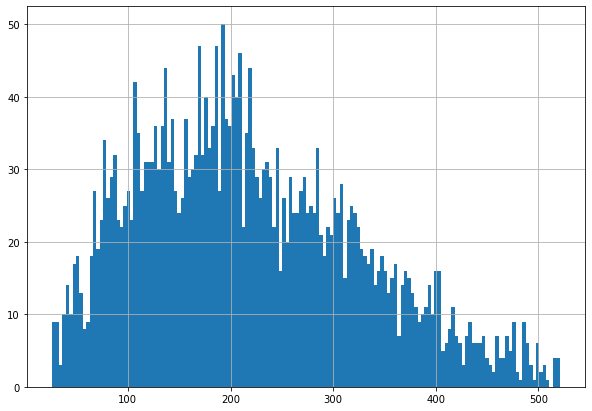

In [61]:
_ = df_nn.total_calories.hist(bins=150, figsize=(10, 7))

# Train Neural Network

In [62]:
IMAGE_SIZE = 224


class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, transform):
        self.images = X["image_path"].reset_index(drop=True)
        self.y = y.reset_index(drop=True)
        self.transform = transform

        assert self.images.shape[0] == self.y.shape[0]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images.iloc[idx]
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        y = self.y.iloc[idx]
        return image, y


data_transforms = {
    "train": transforms.Compose(
        [
            transforms.Resize(IMAGE_SIZE),
            transforms.CenterCrop(IMAGE_SIZE),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(IMAGE_SIZE),
            transforms.CenterCrop(IMAGE_SIZE),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

In [63]:
X_nn_train, X_nn_val, y_nn_train, y_nn_val = train_test_split(
    df_nn[["image_path"]], np.log(df_nn.total_calories), test_size=0.33, random_state=42
)

In [64]:
dataloaders = {
    "train": torch.utils.data.DataLoader(
        ImageDataset(X_nn_train, y_nn_train, data_transforms["train"]),
        batch_size=16,
        shuffle=True,
        num_workers=3,
    ),
    "val": torch.utils.data.DataLoader(
        ImageDataset(X_nn_val, y_nn_val, data_transforms["val"]),
        batch_size=16,
        shuffle=True,
        num_workers=3,
    ),
}

dataset_sizes = {"train": X_nn_train.shape[0], "val": X_nn_val.shape[0]}

In [65]:
class CalorieNet(nn.Module):
    def __init__(self, model):
        super(CalorieNet, self).__init__()
        self.features = model.features
        self.regressor = nn.Sequential(nn.Dropout(0.2), nn.Linear(1280, 1))
        for p in self.features.parameters():
            p.requires_grad = False

    def forward(self, x):
        x = self.features(x)
        x = x.mean([2, 3])
        y = self.regressor(x)
        y = y.squeeze()
        return y

In [81]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cpu = torch.device("cpu")
mobile_net = models.mobilenet_v2(pretrained=True)

In [83]:
device

device(type='cuda', index=0)

In [55]:
net = CalorieNet(mobile_net).to(device)

In [85]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    writer = SummaryWriter()
    since = time.time()
    training_loss = []
    validation_loss = []

    for epoch in tqdm(range(num_epochs)):
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            for inputs, targets in dataloaders[phase]:
                inputs = inputs.to(device)
                targets = targets.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)

            if phase == "train":
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            if phase == "train":
                training_loss.append(epoch_loss)
                writer.add_scalar("Loss/train", epoch_loss, epoch)
            else:
                validation_loss.append(epoch_loss)
                writer.add_scalar("Loss/val", epoch_loss, epoch)

    time_elapsed = time.time() - since

    print(f"Training complete in {time_elapsed/60}m {time_elapsed % 60}s")
    writer.close()
    return model, (training_loss, validation_loss)

In [86]:
criterion = nn.L1Loss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [87]:
model, metrics = train_model(
    net, criterion, optimizer, exp_lr_scheduler, num_epochs=500
)

RuntimeError: size mismatch, m1: [106496 x 13], m2: [512 x 1] at /opt/conda/conda-bld/pytorch_1570910687650/work/aten/src/THC/generic/THCTensorMathBlas.cu:290

In [30]:
training_loss, validation_loss = metrics
pd.DataFrame({"training": training_loss, "validation": validation_loss}).plot.line(
    figsize=(15, 10)
)

NameError: name 'metrics' is not defined

In [18]:
predict_dataloader = torch.utils.data.DataLoader(
    ImageDataset(X_nn_val, y_nn_val, data_transforms["val"]),
    batch_size=100,
    shuffle=False,
    num_workers=3,
)

In [19]:
y_pred_nn = []
for inputs, _ in predict_dataloader:
    inputs = inputs.to(device)
    y_pred_nn.append(model_ft(inputs).to(cpu))

/home/mike/.conda/envs/seefood/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/mike/.conda/envs/seefood/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 12 bytes but only got 10. Skipping tag 42037
  " Skipping tag %s" % (size, len(data), tag)
/home/mike/.conda/envs/seefood/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/mike/.conda/envs/seefood/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/mike/.conda/envs/seefood

In [35]:
y_pred_nn_np = torch.flatten(torch.cat(y_pred_nn)).detach().numpy()

In [22]:
df_nn_results = get_metrics("nn", y_nn_val, y_pred_nn_np)
df_nn_results

,experiment_name,r2_score,explained_variance_score,max_error,mean_absolute_error,mean_squared_error,median_absolute_error
0,nn,-0.003538,-0.003538,316.334326,89.685151,11965.420522,80.147565


## Create Baseline

In [23]:
from sklearn.base import BaseEstimator
from sklearn.base import RegressorMixin
from sklearn.utils.validation import check_is_fitted


class BaselineModel(BaseEstimator, RegressorMixin):
    def __init__(self):
        pass

    def fit(self, _, y):
        self.mean_ = y.mean()
        return self

    def predict(self, X):
        check_is_fitted(self, [])

        return np.array(X.shape[0] * [self.mean_])

In [24]:
baseline_model = BaselineModel()

In [25]:
baseline_model.fit(X_nn_train, y_nn_train)

BaselineModel()

In [26]:
y_pred_baseline = baseline_model.predict(X_nn_val)

In [27]:
df_baseline_results = get_metrics("baseline", y_nn_val, y_pred_baseline)
df_baseline_results

,experiment_name,r2_score,explained_variance_score,max_error,mean_absolute_error,mean_squared_error,median_absolute_error
0,baseline,-0.000002,0.0,301.976865,89.552982,11923.256922,80.023135


## Compare NN to Baseline

In [28]:
df_results = pd.concat([df_baseline_results, df_nn_results]).reset_index(drop=True).T
df_results.columns = df_results.loc["experiment_name"].values
df_results = df_results.iloc[1:]

In [29]:
df_results

,baseline,nn
r2_score,-1.92409e-06,-0.00353818
explained_variance_score,0,-0.00353768
max_error,301.977,316.334
mean_absolute_error,89.553,89.6852
mean_squared_error,11923.3,11965.4
median_absolute_error,80.0231,80.1476


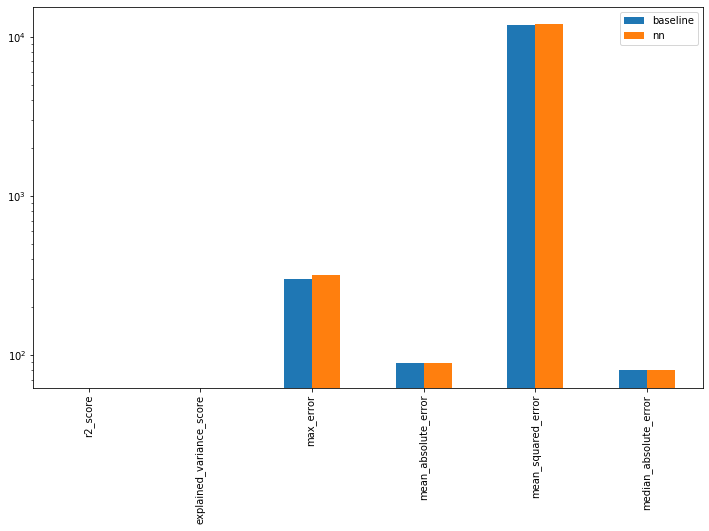

In [30]:
df_results.plot.bar(log=True, figsize=(12, 7))

## Inspect predictions

In [31]:
ylim = (0, 1200)

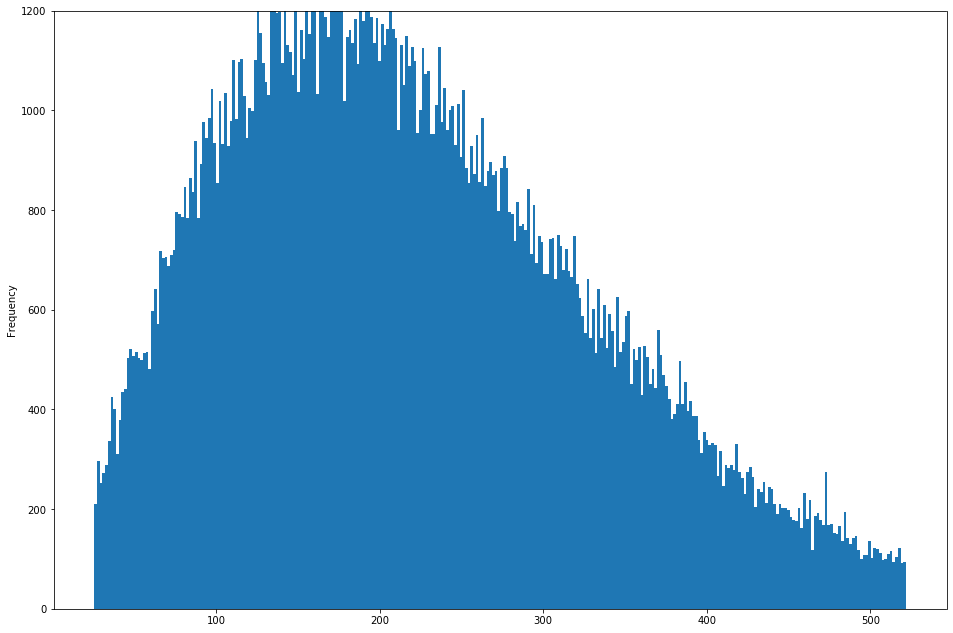

In [32]:
df_nn.loc[X_nn_train.index].total_calories.plot.hist(
    bins=300, figsize=(16, 11), ylim=ylim
)

In [33]:
df_predictions = df_nn.loc[X_nn_val.index].assign(predicted_calories=y_pred_nn_np)

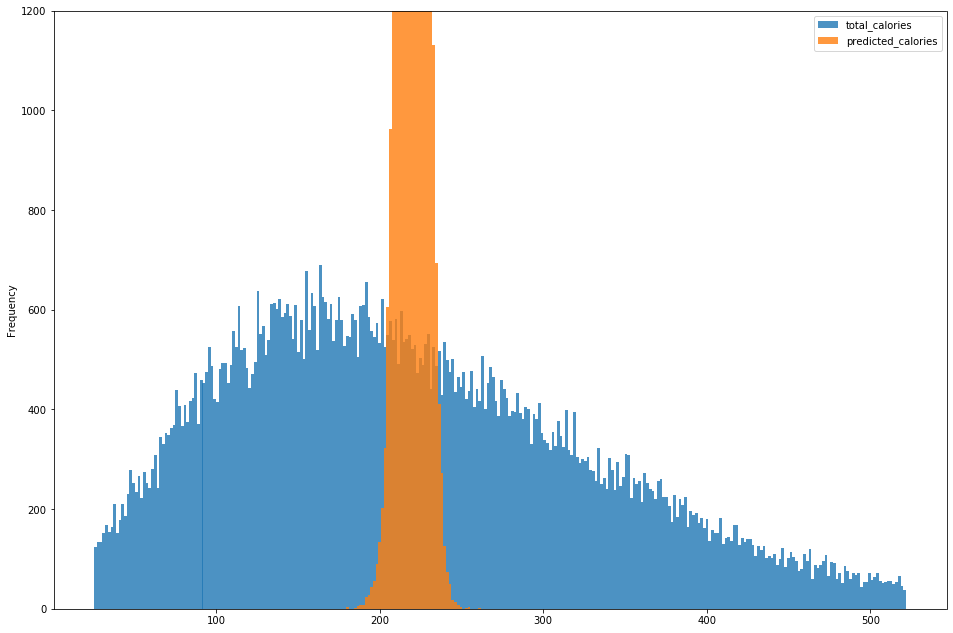

In [34]:
df_predictions[["total_calories", "predicted_calories"]].plot.hist(
    bins=300, figsize=(16, 11), alpha=0.8, ylim=ylim
)

In [252]:
NON_FEATURE_COLS = ["title", "total_calories", "servings", "predicted_calories"]

In [258]:
df_high_cal = df_predictions[df_predictions.predicted_calories > 270]
df_low_cal = df_predictions[df_predictions.predicted_calories < 150]

In [259]:
df_high_cal[NON_FEATURE_COLS].sample(10)

,title,total_calories,servings,predicted_calories
10359,Diana’s Vegetable Frittata,150.5,2.0,225.466766
703077,salsa slow cooker chicken,281.8,10.0,221.748962
428363,OKRA AND TOMATOES,43.8,5.0,212.924301
1008505,Connie's Garlic Lime Spaghetti,414.1,4.0,212.131073
245736,Diet Margaritas,70.0,2.0,216.118134
390308,Russian Borscht,97.6,12.0,215.146118
449996,Ham Vegetable Soup,196.1,10.0,217.114838
793437,zucchini and eggs omelet,29.3,20.0,215.262146
989223,Citrus-Cilantro Fruit Salad,78.1,4.0,215.213760
978355,confetti beans,393.4,2.0,222.711319


In [262]:
df_low_cal[NON_FEATURE_COLS].sample(10)

,title,total_calories,servings,predicted_calories
192191,Chicken Salad Roll-Ups,159.8,6.0,188.006088


In [263]:
df_high_cal[NON_FEATURE_COLS].describe()

,total_calories,servings,predicted_calories
count,63961.000000,63961.000000,63961.000000
mean,220.396786,7.273542,218.741165
std,108.856598,4.133089,4.443501
min,25.600000,2.000000,210.000916
25%,135.800000,4.000000,215.473801
50%,206.200000,6.000000,218.437805
75%,293.900000,9.000000,221.592300
max,521.700000,23.000000,246.523895


In [264]:
df_low_cal[NON_FEATURE_COLS].describe()

,total_calories,servings,predicted_calories
count,1.0,1.0,1.000000
mean,159.8,6.0,188.006088
std,NaN,NaN,NaN
min,159.8,6.0,188.006088
25%,159.8,6.0,188.006088
50%,159.8,6.0,188.006088
75%,159.8,6.0,188.006088
max,159.8,6.0,188.006088


In [265]:
high_cal_wc = WordCloud().generate(" ".join(df_high_cal.title.str.lower()))
low_cal_wc = WordCloud().generate(" ".join(df_low_cal.title.str.lower()))

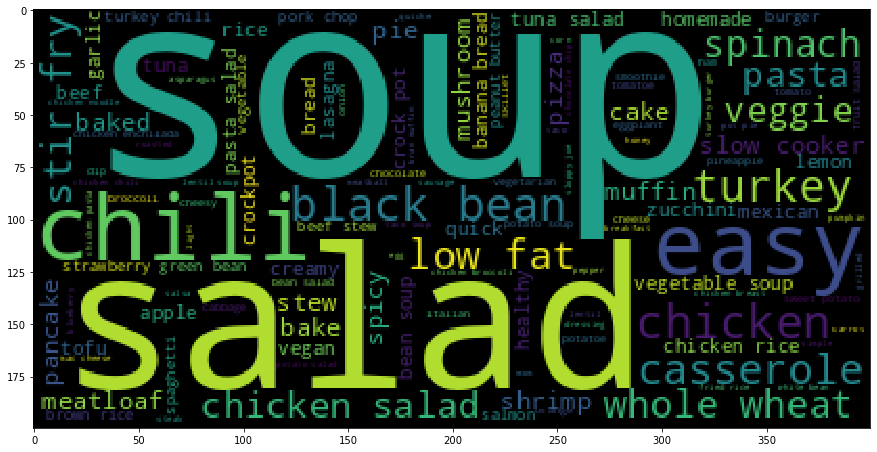

In [266]:
plt.figure(figsize=(15, 15))
plt.imshow(high_cal_wc, interpolation="nearest")

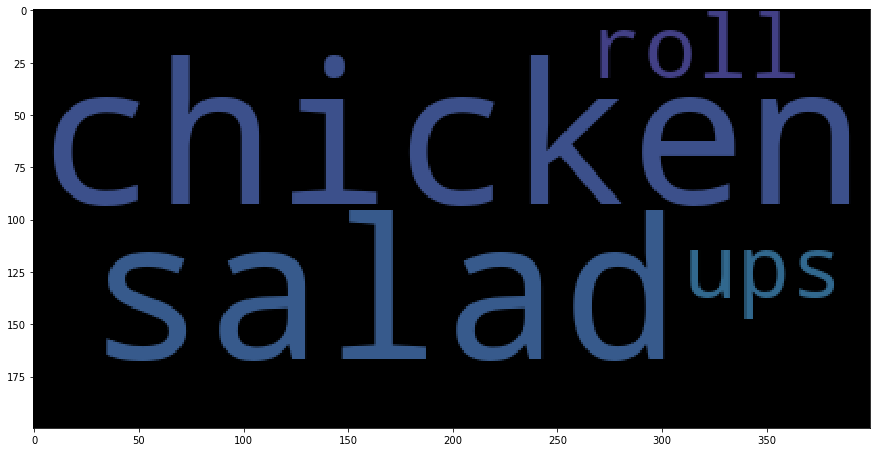

In [267]:
plt.figure(figsize=(15, 15))
plt.imshow(low_cal_wc, interpolation="nearest")

# Persist Model

In [278]:
!ls ../../models

calorie_regression_mobilenet.pt


In [277]:
torch.save(model_ft, "../../models/calorie_regression_mobilenet.pt")

/home/mike/.conda/envs/seefood/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type CalorieNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/mike/.conda/envs/seefood/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/mike/.conda/envs/seefood/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ConvBNReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/mike/.conda/envs/seefood/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon l